In [1]:
# Import libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from queue import PriorityQueue
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
# CIFAR10 dataset
whole_train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transforms.ToTensor(),
                                            download=True)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transforms.ToTensor())
train_dataset, valid_dataset = torch.utils.data.random_split(whole_train_dataset, [40000, 10000])
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
# Batch size of the dataset
batch_size = 64
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
                                           shuffle=True)

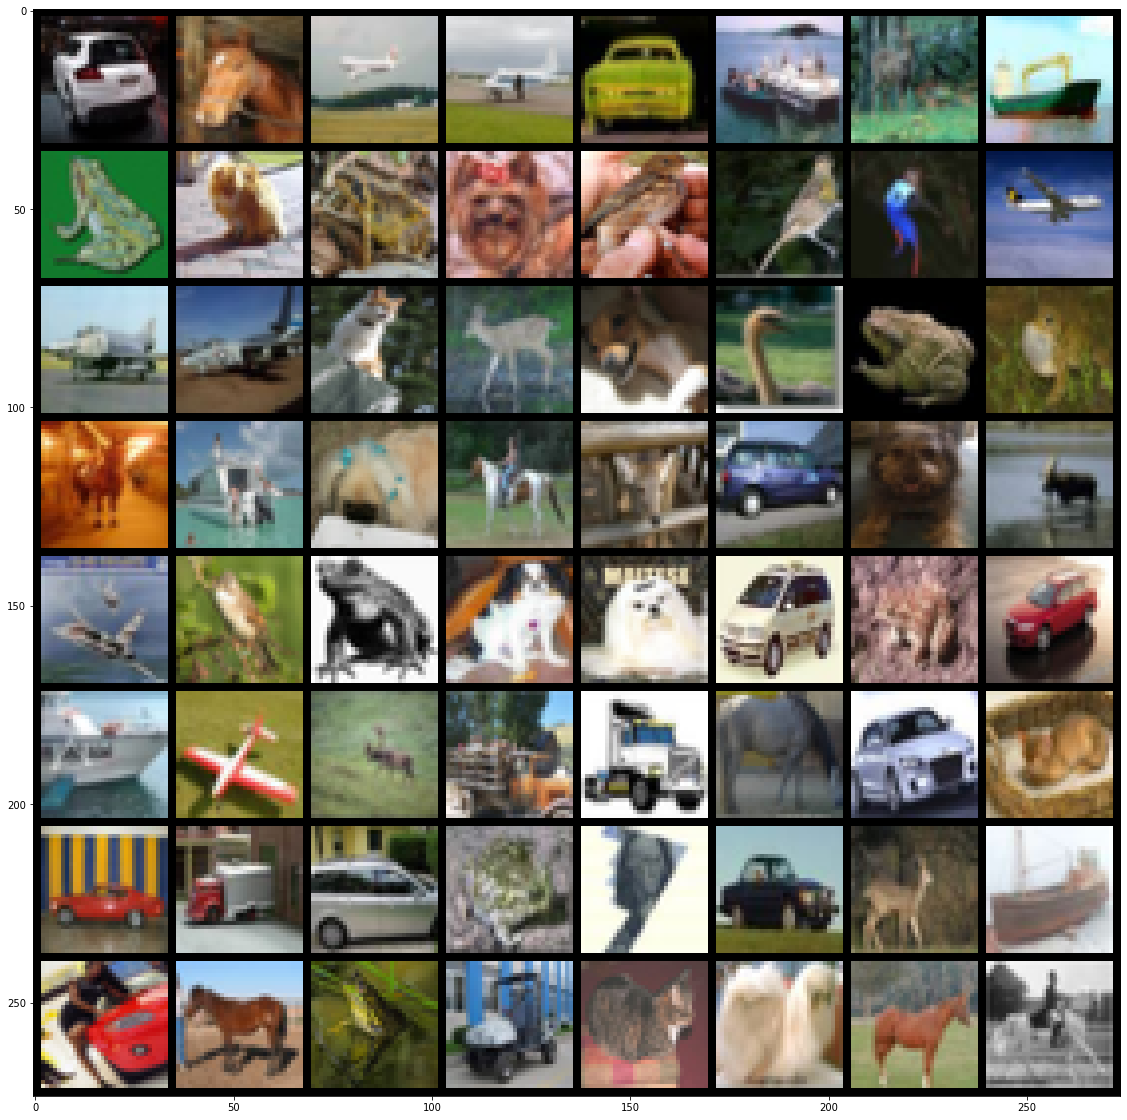

In [4]:
# Visualise a batch of images 
plt.subplots(1,1,figsize=[20,20])
image, label = iter(train_loader).next()
grid_image = torchvision.utils.make_grid(image)
permuted_image = torch.permute(grid_image, (1,2,0))
plt.imshow(permuted_image)
plt.show()

In [5]:
# Original CNN
num_class = 10
class ConvNet(nn.Module):
    def __init__(self, num_class=10):
        super(ConvNet, self).__init__()
        self._layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) # Output size = (32, 16, 16)
        self._layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) # Output size = (64, 8, 8)
        self._layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) # Output size = (128, 4, 4)
        self._layer4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=2048, kernel_size=4, stride=1, padding="valid"),
            nn.ReLU()
        ) # Output size = (2048, 1, 1)
        self._layer5 = nn.Linear(in_features=2048*1*1, out_features=4096)
        self._layer6 = nn.Linear(in_features=4096, out_features=num_class)

        self._layer1_out = None
        self._layer2_out = None
        self._layer3_out = None
        self._layer4_out = None
        self._layer5_out = None
        self._layer6_out = None

    def forward(self, x):
        self._layer1_out = self._layer1(x)
        self._layer2_out = self._layer2(self._layer1_out)
        self._layer3_out = self._layer3(self._layer2_out)
        self._layer4_out = self._layer4(self._layer3_out)
        self._layer5_out = self._layer5(self._layer4_out.reshape(self._layer4_out.size(0), -1))
        self._layer6_out = self._layer6(self._layer5_out)
        return self._layer6_out
    
    def get_layer(self, num_layer):
      if num_layer == 1:
        return self._layer1_out
      elif num_layer == 2:
        return self._layer2_out
      elif num_layer == 3:
        return self._layer3_out
      elif num_layer == 4:
        return self._layer4_out
      elif num_layer == 5:
        return self._layer5_out
      else:
        return self._layer6_out

In [ ]:
# CNN with 1 convolutional block
num_class = 10
class ConvNet1layer(nn.Module):
    def __init__(self, num_class=10):
        super(ConvNet1layer, self).__init__()
        self._layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) # Output size = (32, 16, 16)
        self._layer2 = nn.Linear(in_features=32*16*16, out_features=4096)
        self._layer3 = nn.Linear(in_features=4096, out_features=num_class)

        self._layer1_out = None
        self._layer2_out = None
        self._layer3_out = None

    def forward(self, x):
        self._layer1_out = self._layer1(x)
        self._layer2_out = self._layer2(self._layer1_out.reshape(self._layer1_out.size(0), -1))
        self._layer3_out = self._layer3(self._layer2_out)
        return self._layer3_out
    
    def get_layer(self, num_layer):
      if num_layer == 1:
        return self._layer1_out
      elif num_layer == 2:
        return self._layer2_out
      elif num_layer == 3:
        return self._layer3_out

In [ ]:
# CNN with 2 convolutional block
num_class = 10
class ConvNet2layer(nn.Module):
    def __init__(self, num_class=10):
        super(ConvNet2layer, self).__init__()
        self._layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) # Output size = (32, 16, 16)
        self._layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) # Output size = (64, 8, 8)
        self._layer3 = nn.Linear(in_features=64*8*8, out_features=4096)
        self._layer4 = nn.Linear(in_features=4096, out_features=num_class)

        self._layer1_out = None
        self._layer2_out = None
        self._layer3_out = None
        self._layer4_out = None

    def forward(self, x):
        self._layer1_out = self._layer1(x)
        self._layer2_out = self._layer2(self._layer1_out)
        self._layer3_out = self._layer3(self._layer2_out.reshape(self._layer2_out.size(0), -1))
        self._layer4_out = self._layer4(self._layer3_out)
        return self._layer4_out
    
    def get_layer(self, num_layer):
      if num_layer == 1:
        return self._layer1_out
      elif num_layer == 2:
        return self._layer2_out
      elif num_layer == 3:
        return self._layer3_out
      elif num_layer == 4:
        return self._layer4_out

In [ ]:
# CNN with 1 convolutional block
num_class = 10
class ConvNet3layer(nn.Module):
    def __init__(self, num_class=10):
        super(ConvNet3layer, self).__init__()
        self._layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) # Output size = (32, 16, 16)
        self._layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) # Output size = (64, 8, 8)
        self._layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) # Output size = (128, 4, 4)
        self._layer4 = nn.Linear(in_features=128*4*4, out_features=4096)
        self._layer5 = nn.Linear(in_features=4096, out_features=num_class)

        self._layer1_out = None
        self._layer2_out = None
        self._layer3_out = None
        self._layer4_out = None
        self._layer5_out = None

    def forward(self, x):
        self._layer1_out = self._layer1(x)
        self._layer2_out = self._layer2(self._layer1_out)
        self._layer3_out = self._layer3(self._layer2_out)
        self._layer4_out = self._layer4(self._layer3_out.reshape(self._layer3_out.size(0), -1))
        self._layer5_out = self._layer5(self._layer4_out)
        return self._layer5_out
    
    def get_layer(self, num_layer):
      if num_layer == 1:
        return self._layer1_out
      elif num_layer == 2:
        return self._layer2_out
      elif num_layer == 3:
        return self._layer3_out
      elif num_layer == 4:
        return self._layer4_out
      elif num_layer == 5:
        return self._layer5_out

In [ ]:
# CNN with no max pooling layers
num_class = 10
class ConvNetNoMax(nn.Module):
    def __init__(self, num_class=10):
        super(ConvNetNoMax, self).__init__()
        self._layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="same"),
            nn.ReLU()
        ) # Output size = (32, 32, 32)
        self._layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="same"),
            nn.ReLU()
        ) # Output size = (64, 32, 32)
        self._layer3 = nn.Linear(in_features=64*32*32, out_features=4096)
        self._layer4 = nn.Linear(in_features=4096, out_features=num_class)

        self._layer1_out = None
        self._layer2_out = None
        self._layer3_out = None
        self._layer4_out = None

    def forward(self, x):
        self._layer1_out = self._layer1(x)
        self._layer2_out = self._layer2(self._layer1_out)
        self._layer3_out = self._layer3(self._layer2_out.reshape(self._layer2_out.size(0), -1))
        self._layer4_out = self._layer4(self._layer3_out)
        return self._layer4_out
    
    def get_layer(self, num_layer):
      if num_layer == 1:
        return self._layer1_out
      elif num_layer == 2:
        return self._layer2_out
      elif num_layer == 3:
        return self._layer3_out
      elif num_layer == 4:
        return self._layer4_out

In [6]:
# DNN
num_class = 10
class DenseNet(nn.Module):
    def __init__(self, num_class=10):
        super(DenseNet, self).__init__()

        self._layer1 = nn.Sequential(
            nn.Linear(in_features=32*32*3, out_features=512),
            nn.ReLU()
        ) # Output size = (1, 512)
        self._layer2 = nn.Sequential(
            nn.Linear(in_features=512, out_features=1024),
            nn.ReLU()
        ) # Output size = (1, 1024)
        self._layer3 = nn.Sequential(
            nn.Linear(in_features=1024, out_features=2048),
            nn.ReLU()
        ) # Output size = (1, 2048)
        self._layer4 = nn.Sequential(
            nn.Linear(in_features=2048, out_features=4096),
            nn.ReLU()
        ) # Output size = (1,4096)
        self._layer5 = nn.Linear(in_features=4096, out_features=num_class)

        self._layer1_out = None
        self._layer2_out = None
        self._layer3_out = None
        self._layer4_out = None
        self._layer5_out = None

    def forward(self, x):
      x = x.reshape(-1, 32*32*3)
      self._layer1_out = self._layer1(x)
      self._layer2_out = self._layer2(self._layer1_out)
      self._layer3_out = self._layer3(self._layer2_out)
      self._layer4_out = self._layer4(self._layer3_out)
      self._layer5_out = self._layer5(self._layer4_out)
      return self._layer5_out
    
    def get_layer(self, num_layer):
      if num_layer == 1:
        return self._layer1_out
      elif num_layer == 2:
        return self._layer2_out
      elif num_layer == 3:
        return self._layer3_out
      elif num_layer == 4:
        return self._layer4_out
      else:
        return self._layer5_out

In [7]:
# Train function for neural networks
def train(model, criterion, learning_rate, optimizer, train_loader, valid_loader, num_epoch=30, n_no_improvement=5):
  # Parameters to be defined
  total_steps = len(train_loader)
  train_accuracy = 0
  train_accuracy_list = []
  valid_accuracy = 0
  best_valid_accuracy = 0
  no_improvement = 0
  valid_accuracy_list = []
  loss_list = []
  # Forward feed and Optimization
  for epoch in range(num_epoch):
      for i, (image, label) in enumerate(train_loader):
        # Load a batch of data
        image = image.to(device)
        label = label.to(device)

        # Put data into the neural network
        output = model(image)
        # Evaluate the loss 
        loss = criterion(output, label)
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      # Save loss into a list for the learning curve
      loss_list.append(loss.item())

      # Neural network evaluation in the training set
      model.eval()
      with torch.no_grad():
          train_correct = 0
          train_total = 0
          for image, label in train_loader:
              image = image.to(device)
              label = label.to(device)
              
              output = model(image)
              _, predicted = torch.max(output.data, 1)
              train_total += label.size(0)
              train_correct += (predicted == label).sum().item()

      # Save training set accuracy for the learning curve
      train_accuracy = train_correct/train_total*100
      train_accuracy_list.append(train_accuracy)
      
      # Neural network evaluation in the validation set
      with torch.no_grad():
          valid_correct = 0
          valid_total = 0
          for image, label in valid_loader:
              image = image.to(device)
              label = label.to(device)
              
              output = model(image)
              _, predicted = torch.max(output.data, 1)
              valid_total += label.size(0)
              valid_correct += (predicted == label).sum().item()

      # Save training set accuracy for the learning curve
      valid_accuracy = valid_correct/valid_total*100
      valid_accuracy_list.append(valid_accuracy)
      print(f"Epoch[{epoch+1}/{num_epoch}], Loss:{loss.item()}, Training Accuracy: {train_accuracy}%, Validation Accuaracy: {valid_accuracy}%")
      
      # Early stopping
      if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy
        no_improvement = 0
      else:
        no_improvement += 1
      if no_improvement == n_no_improvement:
        break
  return model, loss_list, train_accuracy_list, valid_accuracy_list

# Learning curve function
def learning_curve(save=False, path=None, title=None, train_accuracy_list=None, valid_accuracy_list=None, loss_list=None):
    fig, ax = plt.subplots(1,1,figsize=[8,8])
    ax.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, marker=".", label="training ")
    ax.plot([i for i in range(len(valid_accuracy_list))], valid_accuracy_list, marker=".", label="validation ")
    ax.plot([i for i in range(len(loss_list))], loss_list, marker=".", label="training loss")
    ax.set_title(title)
    ax.set_xlabel("Epoch") 
    ax.set_ylabel("Accuracy(%)")
    plt.legend()
    if save == True:
      fig.savefig(path)

Epoch[1/30], Loss:1.834172248840332, Training Accuracy: 39.9075%, Validation Accuaracy: 39.45%
Epoch[2/30], Loss:1.1700890064239502, Training Accuracy: 51.370000000000005%, Validation Accuaracy: 49.7%
Epoch[3/30], Loss:1.1501590013504028, Training Accuracy: 59.545%, Validation Accuaracy: 56.379999999999995%
Epoch[4/30], Loss:1.097917914390564, Training Accuracy: 61.4425%, Validation Accuaracy: 57.68%
Epoch[5/30], Loss:0.8922512531280518, Training Accuracy: 74.21%, Validation Accuaracy: 65.8%
Epoch[6/30], Loss:0.5716832876205444, Training Accuracy: 79.535%, Validation Accuaracy: 67.81%
Epoch[7/30], Loss:0.49166393280029297, Training Accuracy: 87.88%, Validation Accuaracy: 70.28%
Epoch[8/30], Loss:0.6343632936477661, Training Accuracy: 91.435%, Validation Accuaracy: 69.89%
Epoch[9/30], Loss:0.3750077486038208, Training Accuracy: 92.8425%, Validation Accuaracy: 69.45%
Epoch[10/30], Loss:0.22277632355690002, Training Accuracy: 96.2525%, Validation Accuaracy: 70.15%


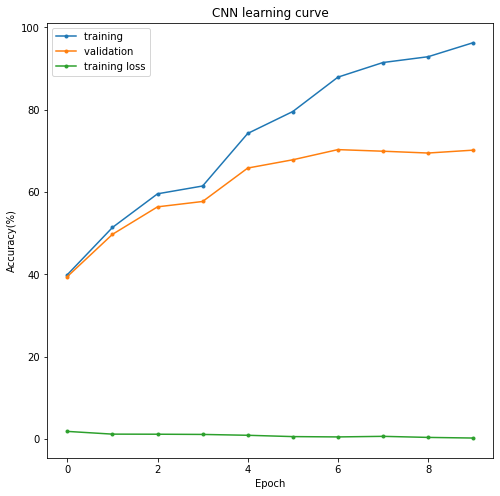

In [12]:
# Train an original CNN
cnn_model = ConvNet(num_class=10).to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(params=cnn_model.parameters(), lr=learning_rate)
train_loader = train_loader
valid_loader = valid_loader
num_epoch = 30
n_no_improvement = 3
cnn_model, loss_list, train_accuracy_list, valid_accuracy_list = train(cnn_model, criterion, learning_rate, optimizer, train_loader, valid_loader, num_epoch, n_no_improvement)
learning_curve(save=True, path="cnn_model_original_lc", train_accuracy_list=train_accuracy_list, valid_accuracy_list=valid_accuracy_list, loss_list=loss_list, title="CNN learning curve")

Epoch[1/30], Loss:1.4435992240905762, Training Accuracy: 44.5575%, Validation Accuaracy: 43.32%
Epoch[2/30], Loss:1.36066472530365, Training Accuracy: 47.2025%, Validation Accuaracy: 45.23%
Epoch[3/30], Loss:1.3569222688674927, Training Accuracy: 59.99250000000001%, Validation Accuaracy: 55.28999999999999%
Epoch[4/30], Loss:1.1947115659713745, Training Accuracy: 60.614999999999995%, Validation Accuaracy: 55.589999999999996%
Epoch[5/30], Loss:1.1874756813049316, Training Accuracy: 62.517500000000005%, Validation Accuaracy: 56.910000000000004%
Epoch[6/30], Loss:0.9373486042022705, Training Accuracy: 66.1225%, Validation Accuaracy: 59.17%
Epoch[7/30], Loss:0.6569656729698181, Training Accuracy: 64.6525%, Validation Accuaracy: 57.13%
Epoch[8/30], Loss:0.9363547563552856, Training Accuracy: 67.755%, Validation Accuaracy: 59.03%
Epoch[9/30], Loss:1.0311768054962158, Training Accuracy: 70.4025%, Validation Accuaracy: 60.25%
Epoch[10/30], Loss:1.120340347290039, Training Accuracy: 68.07%, Vali

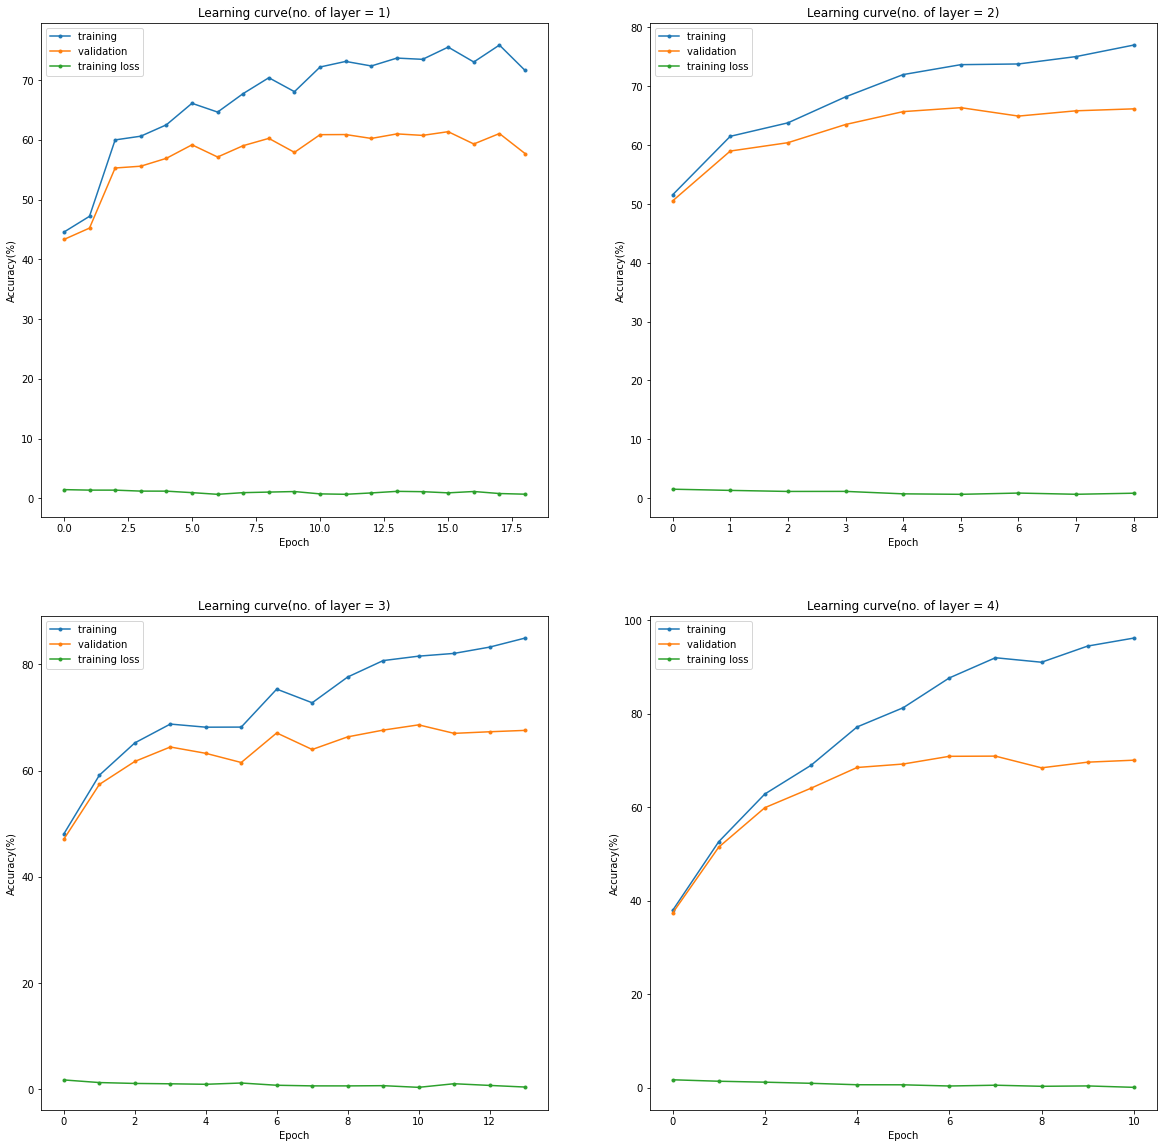

In [ ]:
# Train CNNs with 1, 2, 3, 4 convolutional blocks
fig, ax = plt.subplots(2,2,figsize=[20,20])
axis = [(0,0),(0,1),(1,0),(1,1)]
train_accuracy_max = []
valid_accuracy_max = []
loss_min = []
for index, CNN in enumerate([ConvNet1layer, ConvNet2layer, ConvNet2layer, ConvNet]):
  cnn_model = CNN(num_class=10).to(device)
  criterion = nn.CrossEntropyLoss()
  learning_rate = 0.1
  optimizer = torch.optim.SGD(params=cnn_model.parameters(), lr=learning_rate)
  train_loader = train_loader
  valid_loader = valid_loader
  num_epoch = 30
  n_no_improvement = 3
  cnn_model, loss_list, train_accuracy_list, valid_accuracy_list = train(cnn_model, criterion, learning_rate, optimizer, train_loader, valid_loader, num_epoch, n_no_improvement)
  train_accuracy_max.append(max(train_accuracy_list))
  valid_accuracy_max.append(max(valid_accuracy_list))
  loss_min.append(min(loss_list))
  row, column = axis[index]
  ax[row][column].plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, marker=".", label="training ")
  ax[row][column].plot([i for i in range(len(valid_accuracy_list))], valid_accuracy_list, marker=".", label="validation ")
  ax[row][column].plot([i for i in range(len(loss_list))], loss_list, marker=".", label="training loss")
  ax[row][column].set_title(f"Learning curve(no. of layer = {index+1})")
  ax[row][column].set_xlabel("Epoch") 
  ax[row][column].set_ylabel("Accuracy(%)")
  ax[row][column].legend()

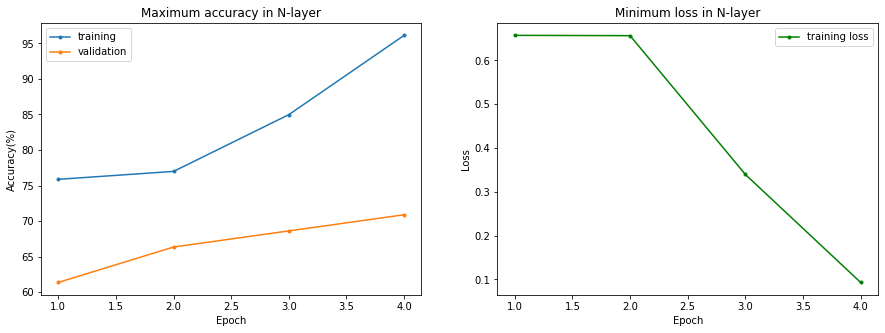

In [ ]:
# Plot the maximum accuracy in traiing set, validation set and minimum loss of CNN with 1, 2, 3, 4 convolutional blocks
fig, ax = plt.subplots(1,2,figsize=[15,5])
ax[0].plot([i+1 for i in range(len(train_accuracy_max))], train_accuracy_max, marker=".", label="training")
ax[0].plot([i+1 for i in range(len(valid_accuracy_max))], valid_accuracy_max, marker=".", label="validation")
ax[1].plot([i+1 for i in range(len(loss_min))], loss_min, marker=".", label="training loss", c="green")
ax[0].set_title(f"Maximum accuracy in N-layer")
ax[0].set_xlabel("Epoch") 
ax[0].set_ylabel("Accuracy(%)")
ax[0].legend()
ax[1].set_title(f"Minimum loss in N-layer")
ax[1].set_xlabel("Epoch") 
ax[1].set_ylabel("Loss")
ax[1].legend()
fig.savefig("cnn_layer_summary.png")

Epoch[1/50], Loss:1.7979432344436646, Training Accuracy: 37.0%, Validation Accuaracy: 37.21%
Epoch[2/50], Loss:1.31745183467865, Training Accuracy: 51.127500000000005%, Validation Accuaracy: 50.6%
Epoch[3/50], Loss:1.158024549484253, Training Accuracy: 60.540000000000006%, Validation Accuaracy: 57.25%
Epoch[4/50], Loss:1.2576788663864136, Training Accuracy: 64.7175%, Validation Accuaracy: 60.07%
Epoch[5/50], Loss:0.8490377068519592, Training Accuracy: 73.165%, Validation Accuaracy: 65.57%
Epoch[6/50], Loss:0.7441189885139465, Training Accuracy: 80.825%, Validation Accuaracy: 68.73%
Epoch[7/50], Loss:0.5174120664596558, Training Accuracy: 86.1275%, Validation Accuaracy: 69.85%
Epoch[8/50], Loss:0.5251293778419495, Training Accuracy: 90.3725%, Validation Accuaracy: 70.39999999999999%
Epoch[9/50], Loss:0.39576414227485657, Training Accuracy: 94.1575%, Validation Accuaracy: 70.78%
Epoch[10/50], Loss:0.38876891136169434, Training Accuracy: 95.705%, Validation Accuaracy: 70.32000000000001%
E

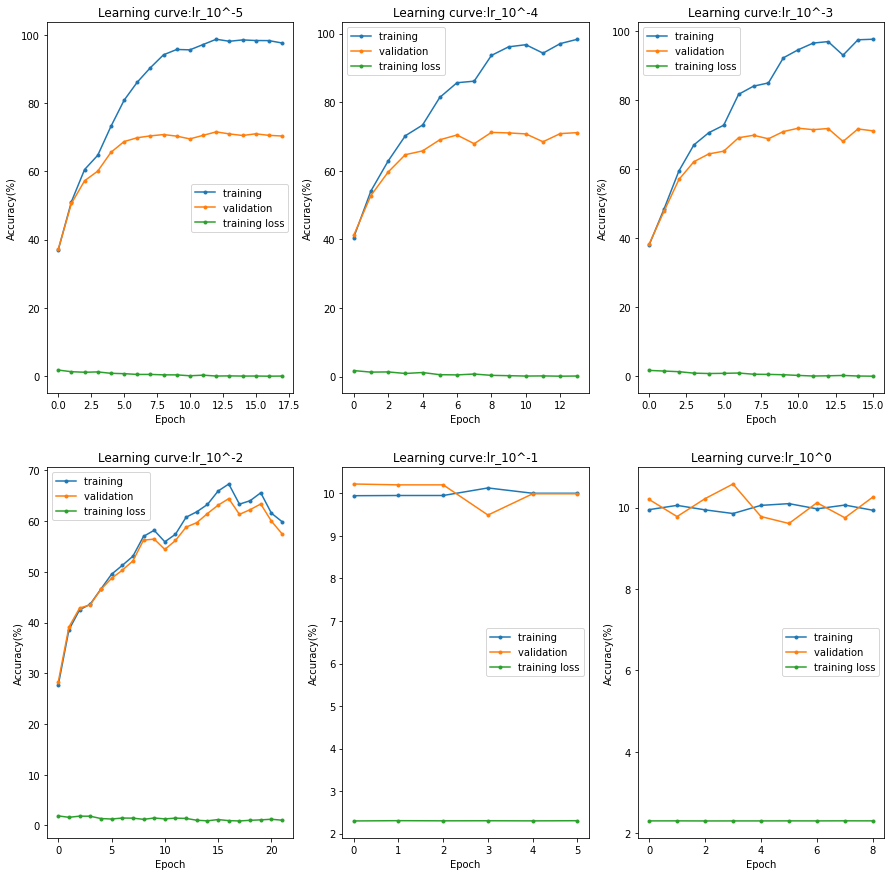

In [7]:
# Train CNNs with 10^-5 to 10^0 L2 regularization
fig, ax = plt.subplots(2,3, figsize=[15,15])
row_column = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)]
index = 0
for index, alpha in enumerate([-5, -4, -3, -2, -1, 0]):
  cnn_model = ConvNet(num_class=10).to(device)
  criterion = nn.CrossEntropyLoss()
  learning_rate = 0.1
  optimizer = torch.optim.SGD(params=cnn_model.parameters(), lr=learning_rate, weight_decay = 10**alpha)
  train_loader = train_loader
  valid_loader = valid_loader
  num_epoch = 50
  n_no_improvement = 5
  cnn_model, loss_list, train_accuracy_list, valid_accuracy_list = train(cnn_model, criterion, learning_rate, optimizer, train_loader, valid_loader, num_epoch, n_no_improvement)
  row, column = row_column[index]
  ax[row][column].plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, marker=".", label="training ")
  ax[row][column].plot([i for i in range(len(valid_accuracy_list))], valid_accuracy_list, marker=".", label="validation ")
  ax[row][column].plot([i for i in range(len(loss_list))], loss_list, marker=".", label="training loss")
  ax[row][column].set_title(f"Learning curve(L2:10^{alpha})")
  ax[row][column].set_xlabel("Epoch") 
  ax[row][column].set_ylabel("Accuracy(%)")
  ax[row][column].legend()

Epoch[1/30], Loss:1.726396918296814, Training Accuracy: 30.885%, Validation Accuaracy: 30.380000000000003%
Epoch[2/30], Loss:1.938817024230957, Training Accuracy: 37.28%, Validation Accuaracy: 37.15%
Epoch[3/30], Loss:1.8413617610931396, Training Accuracy: 39.1475%, Validation Accuaracy: 38.46%
Epoch[4/30], Loss:1.6248738765716553, Training Accuracy: 42.78%, Validation Accuaracy: 40.73%
Epoch[5/30], Loss:1.7452144622802734, Training Accuracy: 41.4825%, Validation Accuaracy: 40.089999999999996%
Epoch[6/30], Loss:1.5426400899887085, Training Accuracy: 49.075%, Validation Accuaracy: 46.18%
Epoch[7/30], Loss:1.4607850313186646, Training Accuracy: 47.557500000000005%, Validation Accuaracy: 44.55%
Epoch[8/30], Loss:1.3142403364181519, Training Accuracy: 52.68000000000001%, Validation Accuaracy: 48.449999999999996%
Epoch[9/30], Loss:1.5302914381027222, Training Accuracy: 52.845%, Validation Accuaracy: 48.25%
Epoch[10/30], Loss:1.3847599029541016, Training Accuracy: 55.754999999999995%, Valida

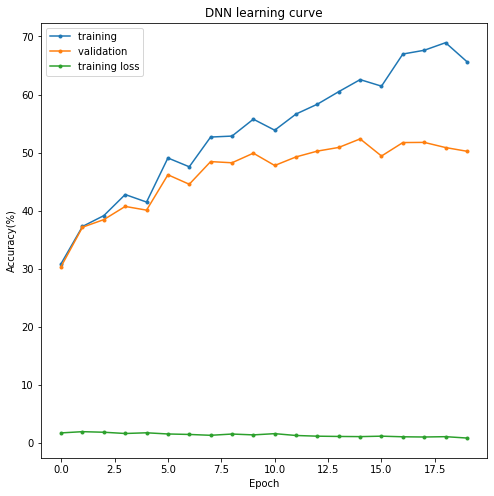

In [13]:
# Train a dense neural network
dense_model = DenseNet(num_class=10).to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(params=dense_model.parameters(), lr=learning_rate)
train_loader = train_loader
valid_loader = valid_loader
num_epoch = 30
n_no_improvement = 5
dense_model, loss_list, train_accuracy_list, valid_accuracy_list = train(dense_model, criterion, learning_rate, optimizer, train_loader, valid_loader, num_epoch, n_no_improvement)
learning_curve(save=True, path="dense_model_lc", title="DNN learning curve", train_accuracy_list=train_accuracy_list, valid_accuracy_list=valid_accuracy_list, loss_list=loss_list)

Epoch[1/30], Loss:1.4803636074066162, Training Accuracy: 45.81%, Validation Accuaracy: 44.31%
Epoch[2/30], Loss:1.0424985885620117, Training Accuracy: 63.375%, Validation Accuaracy: 57.720000000000006%
Epoch[3/30], Loss:1.00474214553833, Training Accuracy: 68.5975%, Validation Accuaracy: 59.160000000000004%
Epoch[4/30], Loss:0.9432967305183411, Training Accuracy: 73.85249999999999%, Validation Accuaracy: 60.92999999999999%
Epoch[5/30], Loss:1.0646564960479736, Training Accuracy: 77.47749999999999%, Validation Accuaracy: 59.650000000000006%
Epoch[6/30], Loss:0.7092303037643433, Training Accuracy: 84.22500000000001%, Validation Accuaracy: 61.29%
Epoch[7/30], Loss:0.39393460750579834, Training Accuracy: 91.13250000000001%, Validation Accuaracy: 61.56%
Epoch[8/30], Loss:0.4810178279876709, Training Accuracy: 91.44%, Validation Accuaracy: 59.58%
Epoch[9/30], Loss:0.31664401292800903, Training Accuracy: 92.7525%, Validation Accuaracy: 58.36%
Epoch[10/30], Loss:0.21612733602523804, Training A

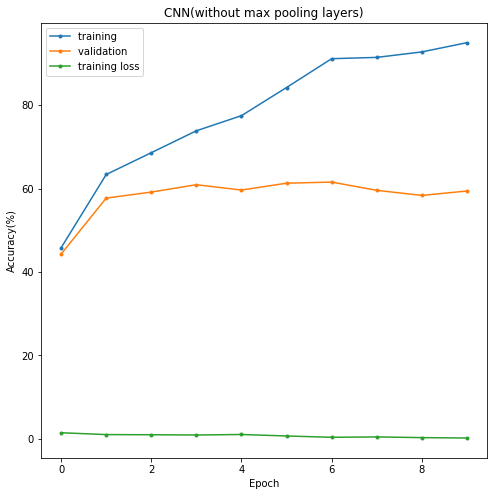

In [ ]:
# Train a CNN with no max pooling layers
start_time = time.time() # Calculate the execution time
cnn_model_nomax = ConvNetNoMax(num_class=10).to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(params=cnn_model_nomax.parameters(), lr=learning_rate)
train_loader = train_loader
valid_loader = valid_loader
num_epoch = 30
n_no_improvement = 3
cnn_model_nomax, loss_list, train_accuracy_list, valid_accuracy_list = train(cnn_model_nomax, criterion, learning_rate, optimizer, train_loader, valid_loader, num_epoch, n_no_improvement)
print("--- %s seconds ---" % (time.time() - start_time)) # Calculate the execution time
learning_curve(save=False, path="cnn_model_nomax_lc", title="CNN(without max pooling layers)", train_accuracy_list=train_accuracy_list, valid_accuracy_list=valid_accuracy_list, loss_list=loss_list)

Epoch[1/30], Loss:1.5683300495147705, Training Accuracy: 47.745%, Validation Accuaracy: 46.25%
Epoch[2/30], Loss:1.3041530847549438, Training Accuracy: 52.66%, Validation Accuaracy: 50.849999999999994%
Epoch[3/30], Loss:1.1676266193389893, Training Accuracy: 66.1675%, Validation Accuaracy: 62.5%
Epoch[4/30], Loss:0.9332227110862732, Training Accuracy: 68.95750000000001%, Validation Accuaracy: 64.63%
Epoch[5/30], Loss:0.9660124778747559, Training Accuracy: 70.08%, Validation Accuaracy: 64.56%
Epoch[6/30], Loss:1.0733729600906372, Training Accuracy: 71.9425%, Validation Accuaracy: 65.19%
Epoch[7/30], Loss:0.9733961820602417, Training Accuracy: 75.78%, Validation Accuaracy: 67.29%
Epoch[8/30], Loss:0.7123333811759949, Training Accuracy: 75.605%, Validation Accuaracy: 66.28%
Epoch[9/30], Loss:0.8251937031745911, Training Accuracy: 78.7025%, Validation Accuaracy: 67.89%
Epoch[10/30], Loss:0.8192508220672607, Training Accuracy: 77.345%, Validation Accuaracy: 66.47%
Epoch[11/30], Loss:0.74166

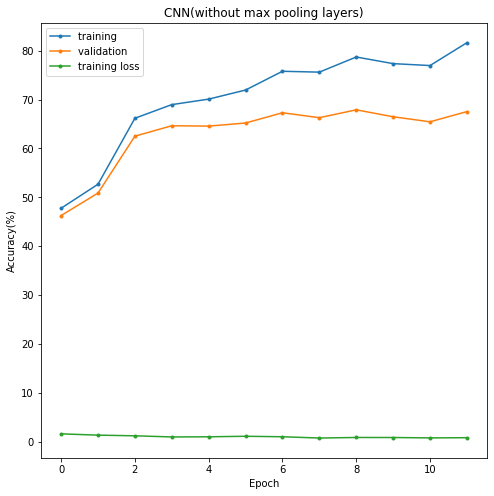

In [ ]:
# Train a CNN with 2 convolutional blocks 
start_time = time.time() # Calculate the execution time
cnn_model2layer = ConvNet2layer(num_class=10).to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(params=cnn_model2layer.parameters(), lr=learning_rate)
train_loader = train_loader
valid_loader = valid_loader
num_epoch = 30
n_no_improvement = 3
cnn_model2layer, loss_list, train_accuracy_list, valid_accuracy_list = train(cnn_model2layer, criterion, learning_rate, optimizer, train_loader, valid_loader, num_epoch, n_no_improvement)
print("--- %s seconds ---" % (time.time() - start_time))
learning_curve(save=False, path="cnn_model_nomax_lc", title="CNN(without max pooling layers)", train_accuracy_list=train_accuracy_list, valid_accuracy_list=valid_accuracy_list, loss_list=loss_list)

deer
deer tensor(63.7309, device='cuda:0')
deer tensor(65.1599, device='cuda:0')
deer tensor(69.8398, device='cuda:0')
frog tensor(72.1103, device='cuda:0')
bird tensor(72.1882, device='cuda:0')
deer tensor(72.5016, device='cuda:0')
truck
truck tensor(122.3137, device='cuda:0')
truck tensor(140.6585, device='cuda:0')
truck tensor(152.1940, device='cuda:0')
truck tensor(152.5486, device='cuda:0')
truck tensor(152.6234, device='cuda:0')
truck tensor(157.1622, device='cuda:0')
truck
car tensor(85.6006, device='cuda:0')
truck tensor(92.2293, device='cuda:0')
truck tensor(94.0501, device='cuda:0')
bird tensor(96.6377, device='cuda:0')
truck tensor(97.7937, device='cuda:0')
plane tensor(97.9414, device='cuda:0')
horse
horse tensor(159.9772, device='cuda:0')
horse tensor(168.3970, device='cuda:0')
horse tensor(176.3793, device='cuda:0')
bird tensor(178.8043, device='cuda:0')
cat tensor(182.6591, device='cuda:0')
dog tensor(184.1456, device='cuda:0')
deer
deer tensor(40.5932, device='cuda:0')


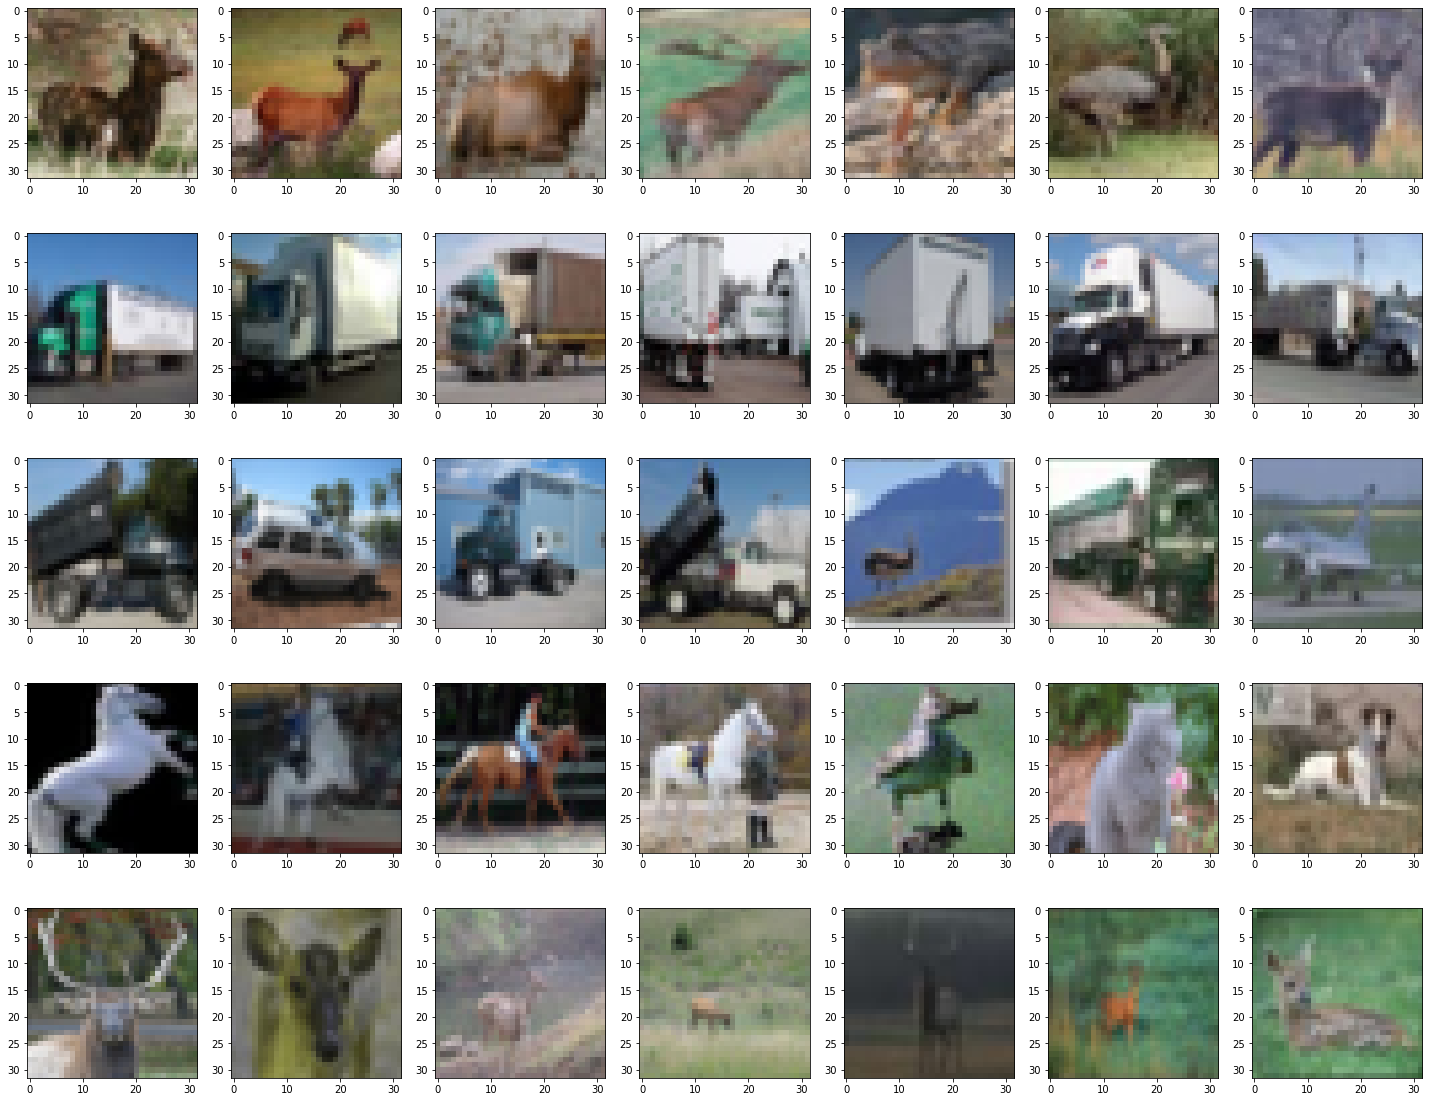

In [ ]:
# Finding the images with highest similarity(lowest Euclidean distance) to the target image
# in term of the output of second fully connected layer
fig, ax = plt.subplots(5,7,figsize=[25,20])
train_image = 0
row = 0
while train_image < 5: # 5 target images
  selected_image, selected_target = train_dataset.__getitem__(train_image) # get the image from the dataset
  selected_image = torch.unsqueeze(selected_image, 0) # Unsqueeze to add an axis to comply the rule of the code
  selected_image = selected_image.to(device)
  _ = cnn_model(selected_image) # Forward feed
  selected_image_flatten = cnn_model.get_layer(5) # Extract the 1x4096 vector
  print(classes[selected_target]) # Print and check the true class


  cnn_model.eval()
  index_nn_pq = PriorityQueue() # A priority queue to sort the similarity
  with torch.no_grad():
    for index, num_image  in enumerate(range(len(valid_dataset))):
      image, target = valid_dataset.__getitem__(num_image)
      image = torch.unsqueeze(image, 0)
      image = image.to(device)
      _ = cnn_model(image)
      image_flatten = cnn_model.get_layer(5)
      # Calculate the Euclidean distance between the target image and the current image
      n_n = torch.sum((selected_image_flatten - image_flatten)**2) 
      # Put the Euclidean distance and image index into the pirority queue
      index_nn_pq.put((n_n, index))

# Display the image
  for column in range(7):
    # Display the target image
    if column == 0:
      selected_image, selected_target = train_dataset.__getitem__(train_image)
      ax[row][column].imshow(torch.permute(selected_image, (1,2,0)))
      continue
    # Display the image with the highest similarity
    n_n, index = index_nn_pq.get() # Dequeue the pirority queue
    image, target = valid_dataset.__getitem__(index) # Get the image
    ax[row][column].imshow(torch.permute(image, (1,2,0))) # Plot the image
    print(classes[target], n_n) # Check the class and the similarity(Euclidean distance)
  row += 1
  train_image += 1

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


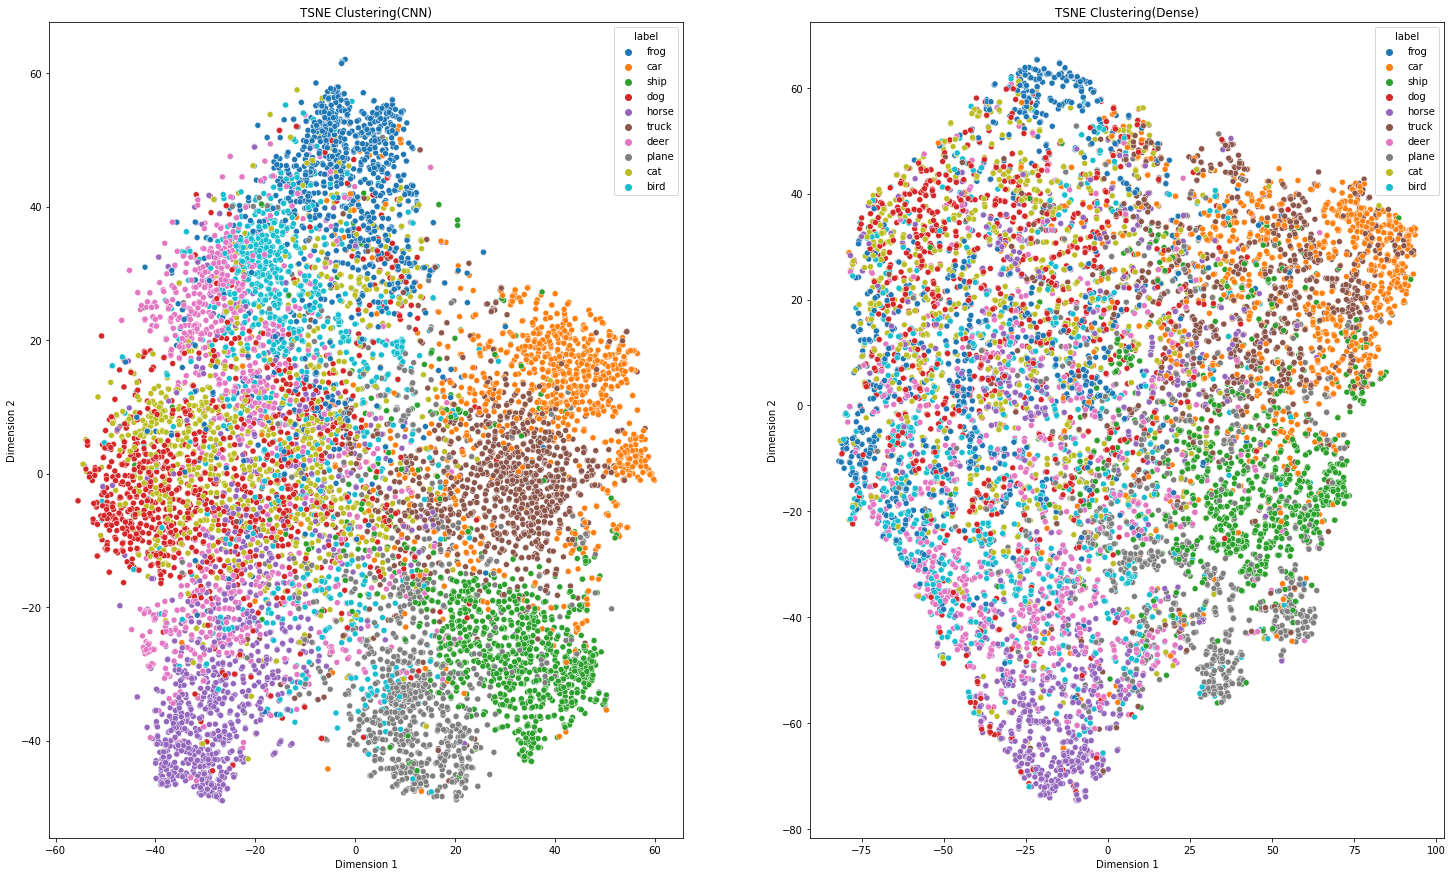

In [ ]:
# Dimension reduction by T-SNE of all 1x4096 vectors from all images
fig, ax = plt.subplots(1,2,figsize=[25,15])
i = 0
for model in [cnn_model, dense_model]:
  # Put all 1x4096 vectors and their label from all images into a list
  flatten_vectors = []
  with torch.no_grad():
    for index, num_image  in enumerate(range(len(valid_dataset))):
      image, target = valid_dataset.__getitem__(num_image)
      image = torch.unsqueeze(image, 0)
      image = image.to(device)
      _ = model(image)
      image_flatten = model.get_layer(5)
      flatten_vectors.append((image_flatten, target))

  # Separate 1x4096 vectors and their labels into two list
  vectors = []
  target_vector = []
  with torch.no_grad():
    for vector in flatten_vectors:
      flatten_image, target = vector
      flatten_image = flatten_image.detach().cpu().numpy().ravel()
      vectors.append(flatten_image)
      target_vector.append(target)
  vectors = np.array(vectors)

  # Perform T-SNE for all 1x4096 vectors to reduce them into 1x2 vectors
  tsne_matrix = TSNE(n_components=2, learning_rate="auto", init="pca").fit_transform(vectors)

  # Put T-SNE results and the labels into dataframe for plotting
  tsne_matrix_df = pd.DataFrame(tsne_matrix, columns=["dim1", "dim2"])
  tsne_matrix_df["label"] = target_vector
  tsne_matrix_df["label"] = tsne_matrix_df["label"].apply(lambda x: classes[x]) # Mapping labels to class names
  sns.scatterplot(x=tsne_matrix_df["dim1"], y=tsne_matrix_df["dim2"], hue=tsne_matrix_df["label"], ax=ax[i]) # Plot the T-SNE results in a scatter plot
  if model == cnn_model:
    ax[i].set_title(f"TSNE Clustering(CNN)")
  else:
    ax[i].set_title(f"TSNE Clustering(Dense)")
  ax[i].set_xlabel("Dimension 1")
  ax[i].set_ylabel("Dimension 2")
  i += 1

In [ ]:
# Overall evaluation of the testing set
cnn_model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for image, label in test_loader:
      image = image.to(device)
      label = label.to(device)
      
      output = cnn_model(image)
      _, predicted = torch.max(output.data, 1)
      total += label.size(0)
      correct += (predicted == label).sum().item()
  print(f"Accuracy: {correct/total*100}%")

Accuracy: 69.74000000000001%


In [14]:
# Evaluation function for a distribution of correct predictions in each class 
def evaluation_class(model, dataset):
  correct_array = np.zeros(10) # Correc count for 10 classes
  total_array = np.zeros(10) # Total count for 10 classes
  with torch.no_grad():
    for i in range(len(test_dataset)):
      image, label = test_dataset.__getitem__(i)
      total_array[label] += 1
      image = torch.unsqueeze(image, 0)
      image = image.to(device)
      output = model(image)
      _, predicted = torch.max(output.data, 1) # Get the index of the highest score class 
      if predicted == label: # Count correct predictions
        correct_array[predicted] += 1
  return correct_array, total_array


(0.0, 1.0)

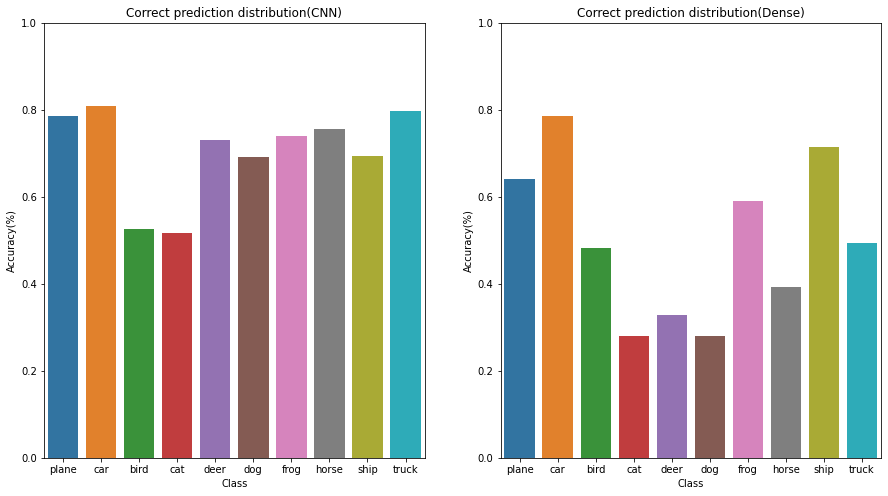

In [16]:
# Plot the distribution
fig, ax = plt.subplots(1,2,figsize=[15,8])
correct_array_cnn, total_array_cnn = evaluation_class(cnn_model, test_dataset)
correct_array_dense, total_array_dense = evaluation_class(dense_model, test_dataset)
sns.barplot(x=classes, y=correct_array_cnn/total_array_cnn, ax=ax[0])
sns.barplot(x=classes, y=correct_array_dense/total_array_dense, ax=ax[1])
ax[0].set_title("Correct prediction distribution(CNN)")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Accuracy(%)")
ax[0].set_ylim([0, 1])
ax[1].set_title("Correct prediction distribution(Dense)")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Accuracy(%)")
ax[1].set_ylim([0, 1])

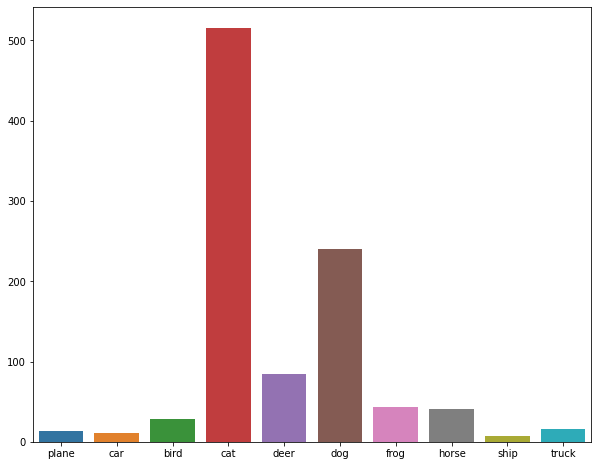

In [26]:
# Plot the distribution of predicting cat images
prediction = np.zeros(10)
total = np.zeros(10)
with torch.no_grad():
  for i in range(len(test_dataset)):
    image, label = test_dataset.__getitem__(i)
    if classes[label] == "cat":
      image = torch.unsqueeze(image, 0)
      image = image.to(device)
      output = cnn_model(image)
      _, predicted = torch.max(output.data, 1)
      prediction[predicted] += 1

fig, ax = plt.subplots(1,1,figsize=[10,8])
sns.barplot(x=classes, y=prediction, ax=ax)
fig.savefig("cat prediction distribution")